## Run of homozygosity analyses

Addresses [issue 10](https://github.com/malariagen/agam-kilifi-report-2017/issues/10)

In [1]:
%run setup.ipynb

In [2]:
# plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
plt.rcParams['figure.dpi'] = 120
%config InlineBackend.figure_formats = {'retina', 'png'}

In [3]:
import popgen

In [4]:
analysis = popgen.analysis.PopulationAnalysis('../data/analysis')
analysis

<PopulationAnalysis at '../data/analysis'>

In [5]:
roh_calls = analysis.open_callset("main_roh")

In [6]:
roh_calls_cross = analysis.open_callset("cross_roh")

In [7]:
populations = ["junju", "mbogolo"]

In [8]:
x_tab_fn = os.path.join("..", "ngs.sanger.ac.uk/production", 
                        "ag1000g/phase1/AR3.1/samples", 
                        "cross.samples.meta.txt")

tbl_cross = pandas.read_table(x_tab_fn, index_col="ox_code").query("role == 'parent'")

In [9]:
analysis.get_population_label("junju")

'Kilifi-Junju (n=13)'

In [10]:
population_ix = {p:analysis.get_population_samples(p) 
                 for p in populations}

In [11]:
tbl_samples = analysis.load_sample_table()

In [12]:
chromosomes = chromosomes[:5]
chromosomes

('2R', '2L', '3R', '3L', 'X')

## Create ROH summary data

In [13]:
colnames = ["nROH", "sumROH"]

In [14]:
genome_size = np.sum(
    [len(analysis.genome_assembly[c]) for c in chromosomes])

In [15]:
# Create table for ag1k p1
mi = pandas.MultiIndex.from_product(
    [tbl_samples.index, chromosomes])

roh_summary = pandas.DataFrame(index=mi, columns=colnames)

In [16]:
# create table for crosses
mi = pandas.MultiIndex.from_product(
    [tbl_cross.index, chromosomes])

roh_summary_cross = pandas.DataFrame(index=mi, columns=colnames)

In [17]:
def summary_roh(y, callfh, min_size=10000):
    
    sample, chrom = y.name
    x = callfh[chrom][sample][:]
    
    if x.shape[0] == 0:
        return 0, 0.0
    
    xlen = np.diff(x, 1)
    
    try:
        meet_t = (xlen >= min_size).reshape((-1,))
        x = x.compress(meet_t, 0)
    except ValueError:
        print(meet_t)
        print(x)
    
    ncalls = x.shape[0]
    rohsum = np.diff(x, 1).sum()
    return ncalls, rohsum

In [18]:
roh_summary = roh_summary.apply(summary_roh, 1, 
                                callfh=roh_calls)

In [19]:
list(roh_calls_cross["2L"].keys())

['AD0231-C',
 'AD0232-C',
 'AD0254-C',
 'AD0255-C',
 'AD0305-C',
 'AD0306-C',
 'AD0347-C',
 'AD0348-C']

In [20]:
roh_summary_cross = roh_summary_cross.apply(summary_roh, 1,
                                            callfh=roh_calls_cross)

In [21]:
roh_summary = pandas.concat([roh_summary, roh_summary_cross])

In [22]:
roh_combined = roh_summary.groupby(level=0).aggregate(np.sum)

In [23]:
roh_combined["fROH"] = roh_combined.sumROH / genome_size

In [24]:
roh_combined.head()

,nROH,sumROH,fROH
AB0085-C,113,16352346,0.070953
AB0087-C,102,10475384,0.045453
AB0088-C,158,17991332,0.078065
AB0089-C,91,12861014,0.055804
AB0090-C,161,11035107,0.047882


In [25]:
tbl_cross["population"] = "colony"
tbl_cross["region"] = tbl_cross["colony_id"] 

In [26]:
tbl_samples = pandas.concat([tbl_samples, tbl_cross])

In [27]:
mm = pandas.merge(roh_combined, tbl_samples, 
                  left_index=True, right_index=True)

## Make plots

In [28]:
def check_pop(x):
    if x.population == "KES":
        return x.region
    else:
        return x.population

In [29]:
mm["population_x"] = mm.apply(check_pop, axis=1)

In [30]:
mm.population_x.value_counts()

CMS               275
UGS               103
BFS                81
BFM                69
AOM                60
GAS                56
GWA                46
Kilifi-Mbogolo     31
GNS                31
Kilifi-Junju       13
colony              8
Name: population_x, dtype: int64

In [31]:
populations

['junju', 'mbogolo']

In [32]:
for p in populations:
    cfg = analysis.config.get_population(p)
    phase1_ar3.pop_colors[cfg["label"]] = cfg["color"]

In [33]:
mm["color"] = mm.population_x.map(phase1_ar3.pop_colors)

In [34]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [35]:
ag1k_pop_list = phase1_ar3.pop_ids[:-1] + ("colony",)

In [36]:
legend_elements = [
    Line2D([0], [0], 
           marker='o', 
           color=phase1_ar3.pop_colors[x], 
           label=phase1_ar3.pop_labels[x],
           markerfacecolor=phase1_ar3.pop_colors[x], 
           markersize=5, 
           linestyle="none", 
           alpha=0.5) for x in ag1k_pop_list]

In [37]:
for p in populations:
    
    cfg = analysis.config.get_population(p)
    
    qq = Line2D([0], [0],
                marker='s', 
                color=cfg["color"],
                label=cfg["label"],
                markerfacecolor=cfg["color"],
                markersize=5, 
                linestyle="none")
    
    legend_elements.append(qq)

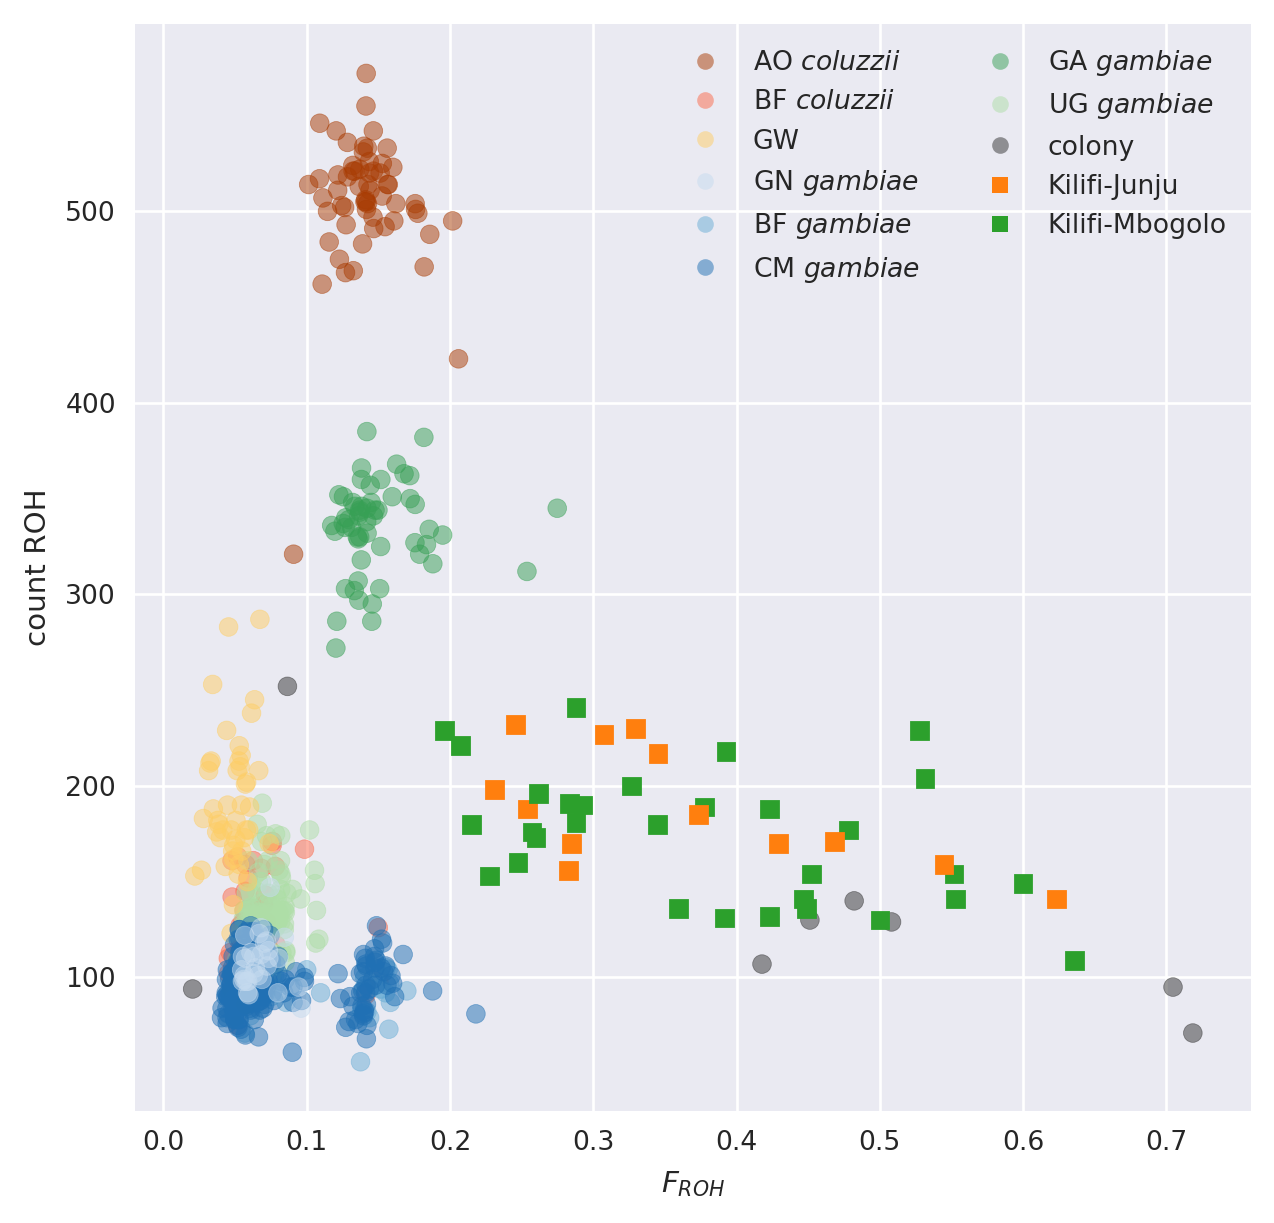

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))

ag1k_pops = mm.query("population != 'KES'")
ax.scatter(ag1k_pops.fROH.values, ag1k_pops.nROH, marker="o",
           color=ag1k_pops.color, alpha=0.5)






# Create the figure
ax.legend(handles=legend_elements, loc=1, ncol=2)

kes_data = mm.query("population == 'KES'")
ax.scatter(kes_data.fROH.values, kes_data.nROH, marker="s", color=kes_data.color)

ax.set_ylabel("count ROH")
ax.set_xlabel(r"$F_{ROH}$")

In [39]:
mm.groupby("population_x").aggregate({"nROH": np.median, "fROH": np.median})

,nROH,fROH
population_x,,
AOM,509.5,0.141429
BFM,113.0,0.061382
BFS,97.0,0.067365
CMS,98.0,0.059821
GAS,338.5,0.141931
GNS,106.0,0.066194
GWA,182.0,0.049796
Kilifi-Junju,185.0,0.329453
Kilifi-Mbogolo,177.0,0.377432


In [40]:
mm.groupby("population_x").aggregate({"nROH": np.mean, "fROH": np.mean})

,nROH,fROH
population_x,,
AOM,505.800000,0.141609
BFM,119.869565,0.065071
BFS,97.283951,0.086334
CMS,98.363636,0.074221
GAS,335.071429,0.150179
GNS,107.483871,0.067325
GWA,190.369565,0.048391
Kilifi-Junju,188.000000,0.363002
Kilifi-Mbogolo,173.838710,0.380303


## Just the KES populations

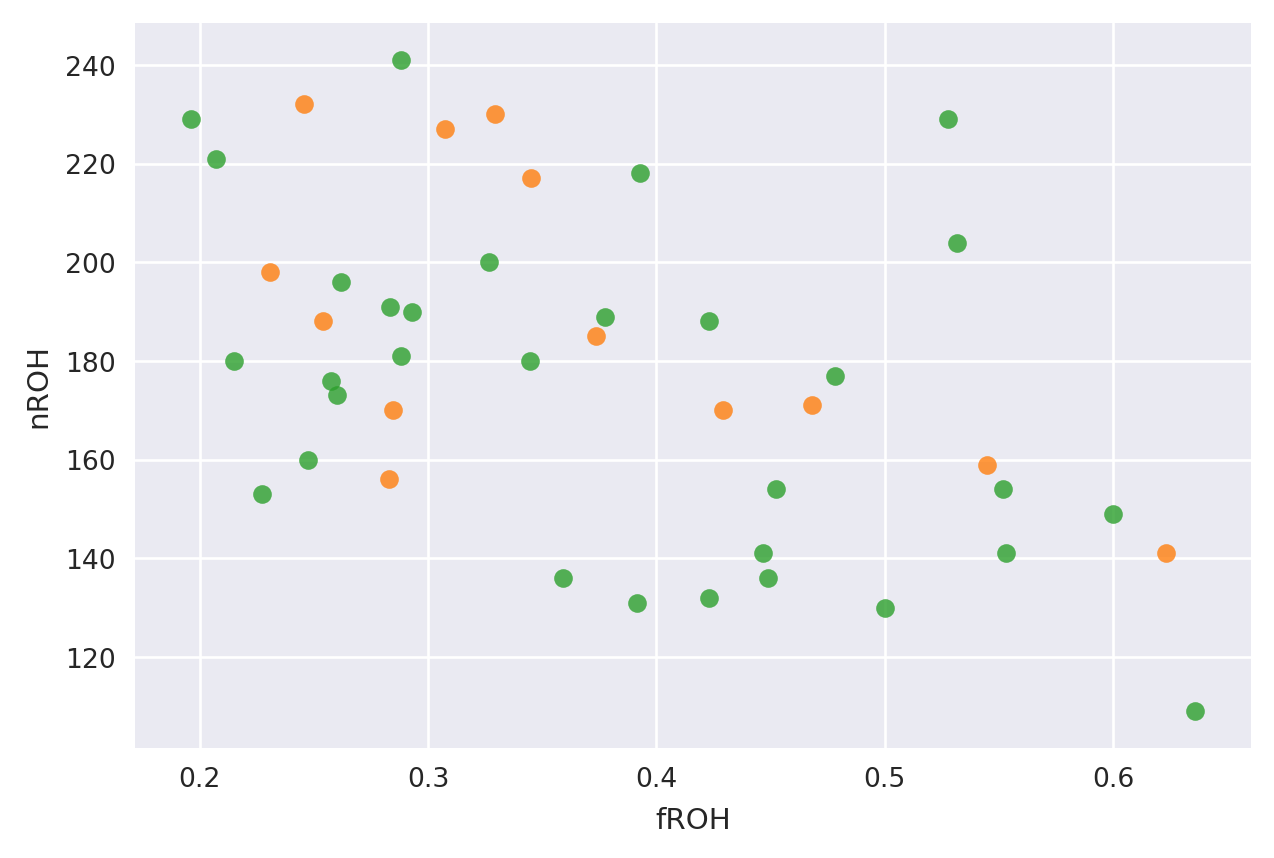

In [41]:
fig, ax = plt.subplots()

for p in populations:
    cfg = analysis.config.get_population(p)
    sns.regplot("fROH", "nROH", 
               data=mm.query(cfg["query"]), 
               color=cfg["color"], fit_reg=False, ax=ax)